# Fitness Classes NYC Recommender System

Now that we have scraped reviews for 1000 companies, we can being creating the recommender system. In this notenbook we will be building it out using the python library _**Surprise**_. We will try out different baseline models to determine find out which algorithm performs best with our data set.

The first step in this process, however is to start with EDA or exploratory data analysis. We will look at the distributions of our data so we can remove rows/reviews/businesses that do not serve us.

Steps:
1. **Read in our pickled dataset**
2. **EDA:**
    - look into how many users we have
    - look at the distributions of ratings
    - avg star rating for each business
    - Num of reviews for each biz. and that distribution.
    - sorted list of the businesses with the most reviews
    - Location distribution
    - rating distribution by user (on avg how many reviewrs did each user leave)
    - Count of how many reviews each user left: sort the list show the top
    
    
3. **Drop Businesses with very few reviews**

__Read in needed libraries:__

In [1]:
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

__Import the pickled dataset & save as a DataFrame:__

In [2]:
pickle_in = open("Data/reviews_newest_497","rb")
example_dict = pickle.load(pickle_in)
start_reviews_df = pd.DataFrame(example_dict)

In [3]:
start_reviews_df

,rev_company_name,rev_comp_url,company_loc,rev_comp_rating,rev_comp_reviews,userUrl,comapny_source
0,Planet Fitness - Manhattan - Canal St - NY,https://www.yelp.com/biz/planet-fitness-manhat...,"370 Canal St New York, NY 10013",3.0,"Planet Fitness is an affordable, no frills gym...",https://www.yelp.com/user_details?userid=exPhu...,Peloton
1,Montauk Salt Cave,https://www.yelp.com/biz/montauk-salt-cave-new...,"90 E 10th St New York, NY 10003",2.0,I purchased a Groupon for a friend and I. When...,https://www.yelp.com/user_details?userid=exPhu...,Peloton
2,Pure Barre - New York Columbus Circle - 60th &...,https://www.yelp.com/biz/pure-barre-new-york-c...,"1841 Broadway New York, NY 11023",3.0,"I enjoyed my class, but this was one of my lea...",https://www.yelp.com/user_details?userid=exPhu...,Peloton
3,Return To Life Center - Pilates and Functional...,https://www.yelp.com/biz/return-to-life-center...,"19 W 45th St New York, NY 10036",4.0,I came in for their Pilates Mat Fundamental cl...,https://www.yelp.com/user_details?userid=exPhu...,Peloton
4,Peloton,https://www.yelp.com/biz/peloton-new-york,"140 W 23rd St New York, NY 10011",4.0,I came in for my first Peloton class awhile ba...,https://www.yelp.com/user_details?userid=exPhu...,Peloton
5,Sonic Yoga,https://www.yelp.com/biz/sonic-yoga-new-york,"944 8th Ave New York, NY 10019",4.0,"I found Sonic on Class Pass, it was a donation...",https://www.yelp.com/user_details?userid=exPhu...,Peloton
6,Daya Yoga Studio,https://www.yelp.com/biz/daya-yoga-studio-bush...,"360 Jefferson St Bushwick, NY 11237",5.0,This is what I think of when I think of a ster...,https://www.yelp.com/user_details?userid=exPhu...,Peloton
7,Simply Fit Astoria,https://www.yelp.com/biz/simply-fit-astoria-as...,"37-20 Astoria Blvd Astoria, NY 11103",5.0,Jesus! I signed up for their Burn the Barre cl...,https://www.yelp.com/user_details?userid=exPhu...,Peloton
8,Exhale Upper East Side,https://www.yelp.com/biz/exhale-upper-east-sid...,"980 Madison Ave New York, NY 10075",5.0,"Wow, this place is really gorgeous. I came for...",https://www.yelp.com/user_details?userid=exPhu...,Peloton
9,Physique 57,https://www.yelp.com/biz/physique-57-new-york-2,"180 6th Ave New York, NY 10013",5.0,I think this was my favorite Barre class yet! ...,https://www.yelp.com/user_details?userid=exPhu...,Peloton


### Exploratory Data Analysis:

__1. Total Count of Users:__

In [4]:
user_count = len(set(start_reviews_df['userUrl']))
business_count= len(set(start_reviews_df['rev_company_name']))
source_companies = len(set(start_reviews_df['comapny_source']))
print(f'There are {user_count} users for {business_count} total businesses reviewed',
     f'There are {user_count} users for {source_companies} source businesses',
     sep='\n\n')

There are 3683 users for 3361 total businesses reviewed

There are 3683 users for 497 source businesses


*****FIX THIS HERE*****

__SO, what *does* this mean?__ The difference in the number of users vs. the number of businesses has an impact on the type of CF recommender system we choose. Due to the users count way out numbering the business count we will be using the __item-itme collaborative fitering__ model (SlopeOne family).

__2. Distributions of ratings:__

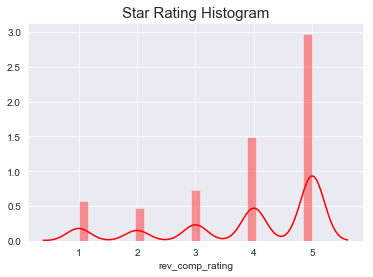

In [5]:
sns.set_style("darkgrid")
sns.distplot(start_reviews_df['rev_comp_rating'],norm_hist=False,color='red')
plt.title('Star Rating Histogram',fontsize=15);
# sns.set(font_scale=1); #used to increate the size of all fonts

Bar chart of value counts for star ratings:

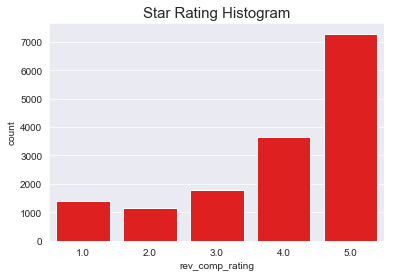

In [6]:
sns.countplot(start_reviews_df['rev_comp_rating'],color='red')
plt.title('Star Rating Histogram',fontsize=15);
# sns.set(font_scale=1)

__3. Avg star rating for businesses__

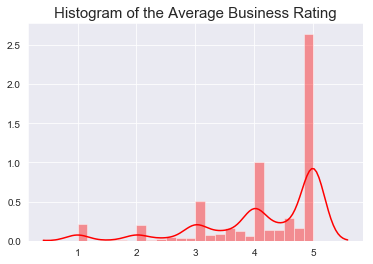

In [7]:
sns.distplot(start_reviews_df.groupby(['rev_company_name']).mean(),color='red')
plt.title('Histogram of the Average Business Rating',fontsize=15);

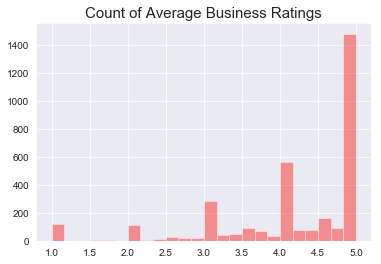

In [33]:
sns.distplot(start_reviews_df.groupby(['rev_company_name']).mean(),color='red',kde=False)
plt.title('Count of Average Business Ratings',fontsize=15);

Ok, now that we look at these some of them have the key words where we know we will not have scraped any more data from them, such as: __'CLOSED'__ and __'Moved'__. So, first things first, lets drop those. But while we're at it, lets __drop the businesses that have less than 2 reviews__.

We use a lambda function applied as a filter on the DataFrame which is grouped by the reviewed company name--the value we need to occur more than once.

In [34]:
reviews_filtered_df = start_reviews_df.groupby('rev_company_name').filter(lambda x: len(x) > 1)
reviews_filtered_df.reset_index(drop=True,inplace=True)

In [35]:
users_filter = start_reviews_df.groupby('userUrl').filter(lambda x: len(x) > 1)
users_filter.reset_index(drop=True,inplace=True)

In [36]:
reviews_filtered_df.rev_company_name.value_counts()[::-1][:10]

Limitless Fitness Studios           2
West Hartford Yoga                  2
Bikram Yoga Bethesda - RENOVATED    2
CKO Kickboxing Clinton Hill         2
The Assemblage NoMad                2
DEFINE body & mind                  2
Ayurvedas World                     2
Stroga - CLOSED                     2
The Pilates Movement                2
Atlantis Sports Club - CLOSED       2
Name: rev_company_name, dtype: int64

In [38]:
users_filter.userUrl.value_counts()[::-1][:10]

https://www.yelp.com/user_details?userid=bR2ASTOdSGq5PPh90pRx9g    2
https://www.yelp.com/user_details?userid=AJ8K-RhbIET8C7at4D-HHQ    2
https://www.yelp.com/user_details?userid=GfwXChKdqbke0dA28p2G5w    2
https://www.yelp.com/user_details?userid=cJqvI4AWkc_pq2e0VCICDA    2
https://www.yelp.com/user_details?userid=KzN__ig1PuibsNwRTmurjA    2
https://www.yelp.com/user_details?userid=sd7is0QNOTZ_xpixfjslNg    2
https://www.yelp.com/user_details?userid=WqNp8IQQ3VI9q6Q7Vxb6Dg    2
https://www.yelp.com/user_details?userid=mgVulK1N7zODR2LdBCfdeg    2
https://www.yelp.com/user_details?userid=36XvjEZdWhBuAk-UxfS1DA    2
https://www.yelp.com/user_details?userid=aesDG2iW5QmVhsbsAzwHBg    2
Name: userUrl, dtype: int64

Ok, so above we can see that the last 10 values for the DataFrame are **_all_ above 1**.

In [39]:
reviews_filtered_df[reviews_filtered_df['rev_company_name']=='Las Vegas Athletic Club']

,rev_company_name,rev_comp_url,company_loc,rev_comp_rating,rev_comp_reviews,userUrl,comapny_source
1930,Las Vegas Athletic Club,https://www.yelp.com/biz/las-vegas-athletic-cl...,"2655 Maryland Pkwy Las Vegas, NV 89109",1.0,would have loved the opportunity to actually v...,https://www.yelp.com/user_details?userid=QtpBG...,New York Sports Clubs
1957,Las Vegas Athletic Club,https://www.yelp.com/biz/las-vegas-athletic-cl...,"2655 Maryland Pkwy Las Vegas, NV 89109",4.0,Did I just step in a time machine back to the ...,https://www.yelp.com/user_details?userid=YttDg...,New York Sports Clubs
6475,Las Vegas Athletic Club,https://www.yelp.com/biz/las-vegas-athletic-cl...,"9065 S Eastern Ave Las Vegas, NV 89123",4.0,No complaints I like the classes they offer.....,https://www.yelp.com/user_details?userid=d2HNq...,Crank Indoor Cycling Studio
10653,Las Vegas Athletic Club,https://www.yelp.com/biz/las-vegas-athletic-cl...,"2655 Maryland Pkwy Las Vegas, NV 89109",2.0,Last day in Vegas started feeling fat. Went t...,https://www.yelp.com/user_details?userid=iQ_Bo...,Dance Manhattan
12985,Las Vegas Athletic Club,https://www.yelp.com/biz/las-vegas-athletic-cl...,"9065 S Eastern Ave Las Vegas, NV 89123",1.0,I have been a member for YEARS. I just walked...,https://www.yelp.com/user_details?userid=B8JUQ...,Lululemon Athletica
13057,Las Vegas Athletic Club,https://www.yelp.com/biz/las-vegas-athletic-cl...,"1725 N Rainbow Blvd Las Vegas, NV 89108",1.0,The trainers here are horrible. They have no s...,https://www.yelp.com/user_details?userid=mxD9I...,Crunch - Bushwick


So, above we can see that there are multiple studios/gyms outside nyc and others that have closed or moved. However, becuse we are doing Item-Item we will keep these for now to help with our users ratings. One thing to consider is that we will not use these if we include location in one of our models. Further, when we give recommendations these will be dropped.

In [40]:
print(f'shape before dropping rows: {start_reviews_df.shape}',
      f'shape after: {reviews_filtered_df.shape}',sep='\n........ YAS :) .......\n')

shape before dropping rows: (15288, 7)
........ YAS :) .......
shape after: (13261, 7)


In [41]:
print(f'shape before dropping rows: {start_reviews_df.shape}',
      f'shape after: {users_filter.shape}',sep='\n........ YAS :) .......\n')

shape before dropping rows: (15288, 7)
........ YAS :) .......
shape after: (15288, 7)


__Numer of reviews for each business:__

In [45]:
reviews_filtered_df.rev_company_name.value_counts()[:10]
# users_filter.rev_company_name.value_counts()[:10] #these are exactly the same

New York Sports Clubs             494
Physique 57                       109
Peloton                            96
Yoga to the People                 91
Mile High Run Club                 86
Pop Physique                       79
New York Sports Clubs - CLOSED     76
305 Fitness                        72
Fhitting Room                      67
Exhale Central Park South          66
Name: rev_company_name, dtype: int64

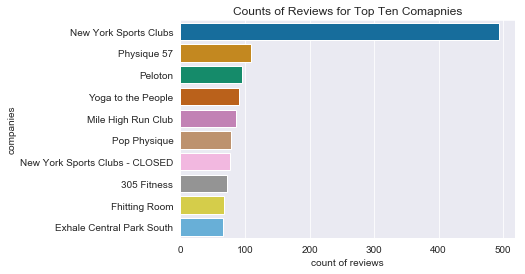

In [44]:
ax = sns.barplot(y=reviews_filtered_df.rev_company_name.value_counts().index[:10],
            x=reviews_filtered_df.rev_company_name.value_counts().values[:10],palette='colorblind')
plt.title('Counts of Reviews for Top Ten Comapnies',fontsize=12)
ax.set(xlabel='count of reviews', ylabel='companies')
sns.set(font_scale=1);
# ax.savefig("review_count_top_10.png")

__Distribution of the review counts:__

We can see that the distribution has a heavily __negative skew__. This is somehting we will need to deal with in later on, either with __over/under sampling or transforming__ our distribution.

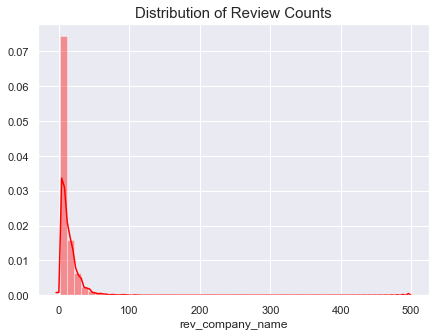

In [47]:
plt.figure(figsize=(7,5))
sns.distplot(reviews_filtered_df.rev_company_name.value_counts(),color='red')
plt.title('Distribution of Review Counts',fontsize=15);

__Location Distributions__: 

Here we will break up each neighborhood into a category and 

__Users averge Ratings and Distributions__:


rating distribution by user (on avg how many reviewrs did each user leave). So, due to us doing collaborative fitering we do not need each user to have left multiple reviews, but we do need them to have left one. Good for us that the majority of people left 2 or more.

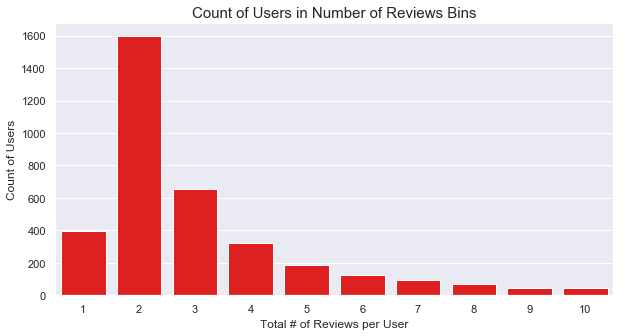

In [46]:
plt.figure(figsize=(10,5))
data = reviews_filtered_df.groupby('userUrl').count().rev_company_name.value_counts()[:10]
ax = sns.barplot(x=data.index, y=data.values,color='red')
plt.title('Count of Users in Number of Reviews Bins',fontsize=15)
plt.xlabel('Total # of Reviews per User')
plt.ylabel('Count of Users');
# plt.setp(ax.get_xticklabels()[:17], rotation=90);

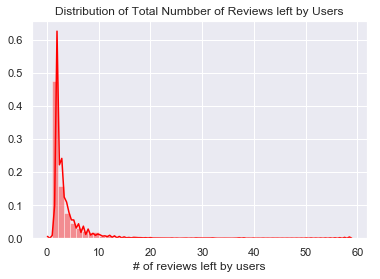

In [48]:
sns.distplot(reviews_filtered_df.groupby('userUrl').count()['rev_company_name'],color='red')
plt.xlabel('# of reviews left by users')
plt.title('Distribution of Total Numbber of Reviews left by Users');

#### Below the same graphs for the df with the filtered out users:

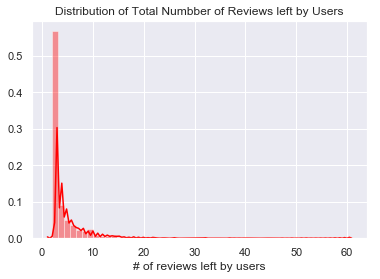

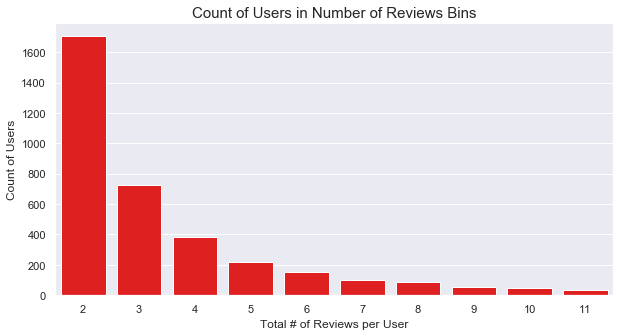

In [50]:
sns.distplot(users_filter.groupby('userUrl').count()['rev_company_name'],color='red')
plt.xlabel('# of reviews left by users')
plt.title('Distribution of Total Numbber of Reviews left by Users');

plt.figure(figsize=(10,5))
data = users_filter.groupby('userUrl').count().rev_company_name.value_counts()[:10]
ax = sns.barplot(x=data.index, y=data.values,color='red')
plt.title('Count of Users in Number of Reviews Bins',fontsize=15)
plt.xlabel('Total # of Reviews per User')
plt.ylabel('Count of Users');
# plt.setp(ax.get_xticklabels()[:17], rotation=90);

In [51]:
#pickle this DataFrame
reviews_filtered_df.to_pickle("Data/filtered_data_2.pkl")
users_filter.to_pickle("Data/filtered_user_data.pkl")

### Dealing with class Imbalance issues:

If we look at the distributions above we can see that some users appear more frequently than others, but also our star ratings are positively skewed. 

In the nect few cells we will try address this issue with a few separate approaches: 

- under sampling
- over sampling using SMOTE (or Synthetic Minorty Over-sampling Technique)

Typically we would go with the first option, so that we are not creating data.

In [ ]:
def in_nyc(x):
    if 'NY' in x:
        return 1
    else: 
        return 0 

reviews_filtered_df['in_NYC'] = reviews_filtered_df.company_loc.apply(lambda x: in_nyc(x))
reviews_filtered_df = reviews_filtered_df[reviews_filtered_df.in_NYC == 1].drop(['in_NYC'],axis=1).reset_index(drop=True)
